In [1]:
from pyVCF import VCF_DataFrame
import os 
import pandas as pd
from tqdm import tqdm

In [2]:
sample_dir = []
for dir in tqdm(os.listdir()):
    if 'SU2CLC' in dir:
        sample_dir.append(dir)

100%|██████████| 107/107 [00:00<00:00, 871437.92it/s]


In [3]:
len(sample_dir)

100

In [4]:
sample_dir[0]

'SU2CLC-DFC-1007'

In [23]:
sample = sample_dir[0]



def somatic_merge(sample):
    count = []
    mutect = VCF_DataFrame.read_vcf(os.path.join(sample, f"{sample}.filtered.vcf"))
    count.append(len(mutect))
    mutect = mutect.filtering()
    count.append(len(mutect))

    varscan_snp = VCF_DataFrame.read_vcf(os.path.join(sample, f"{sample}.somatic.snp.Somatic.hc.vcf"))
    varscan_indel = VCF_DataFrame.read_vcf(os.path.join(sample, f"{sample}.somatic.indel.Somatic.hc.vcf"))
    varscan_som = varscan_snp.concat([varscan_snp,varscan_indel])
    count.append(len(varscan_som))

    varscan_som = varscan_som.filtering()
    count.append(len(varscan_som))

    somatic_2_caller = mutect.merge(varscan_som)
    count.append(len(somatic_2_caller))

    somatic_2_caller.to_vcf(f"{sample}.somatic.merge.vcf")

    return count

In [24]:
def germline_merge(sample):
    count = []
    
    haplotype = VCF_DataFrame.read_vcf(os.path.join(sample, f"{sample}.germline.vcf.gz"))
    count.append(len(haplotype))

    haplotype = haplotype.filter_VAF(germline=True)
    count.append(len(haplotype))

    varscan_snp = VCF_DataFrame.read_vcf(os.path.join(sample, f"{sample}.somatic.snp.Germline.hc.vcf"))
    varscan_indel = VCF_DataFrame.read_vcf(os.path.join(sample, f"{sample}.somatic.indel.Germline.hc.vcf"))
    varscan_germline = VCF_DataFrame.concat([varscan_snp,varscan_indel])
    count.append(len(varscan_germline))

    varscan_germline = varscan_germline.filtering()
    count.append(len(varscan_germline))

    germline_2_caller = haplotype.merge(varscan_germline)
    count.append(len(germline_2_caller))

    germline_2_caller.to_vcf(f"{sample}.germline.merge.vcf")

    return count

In [25]:
germline_count = []
somatic_count = []


for sample in tqdm(sample_dir):
    germline_count.append(germline_merge(sample))
    somatic_count.append(somatic_merge(sample))


100%|██████████| 100/100 [15:30<00:00,  9.31s/it]


In [28]:
germline_count_table = pd.DataFrame(germline_count, columns=['Haplotype(Raw)', "Haplotype(Filtered)", "Varscan(Raw)", "Varscan(Filtered)", "Merged"])
somatic_count_table = pd.DataFrame(somatic_count, columns=['Mutect(Raw)', "Mutect(Filtered)", "Varscan(Raw)", "Varscan(Filtered)", "Merged"])

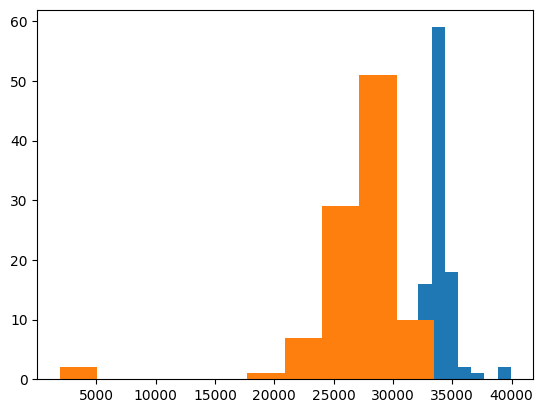

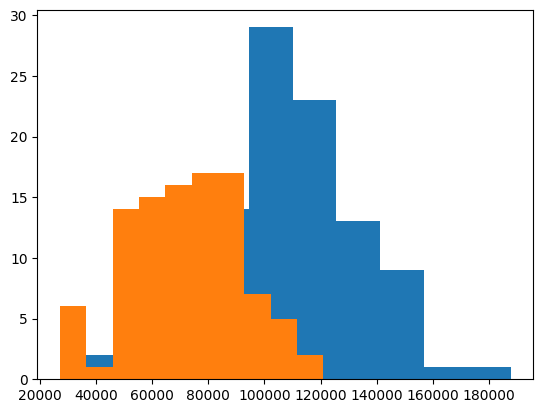

In [ ]:
import matplotlib.pyplot as plt

plt.hist(germline_count_table["Haplotype(Raw)"])
plt.hist(germline_count_table["Haplotype(Filtered)"])
plt.show()
plt.hist(germline_count_table["Varscan(Raw)"])
plt.hist(germline_count_table["Varscan(Filtered)"])
plt.show()

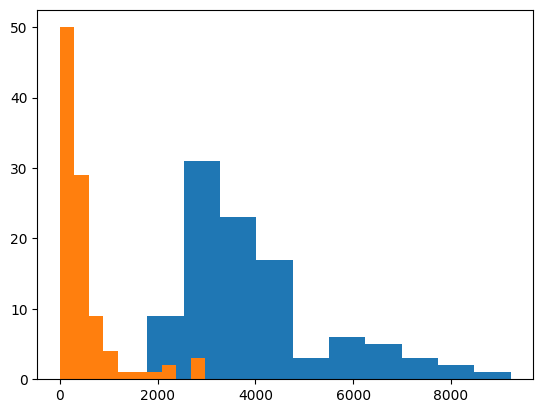

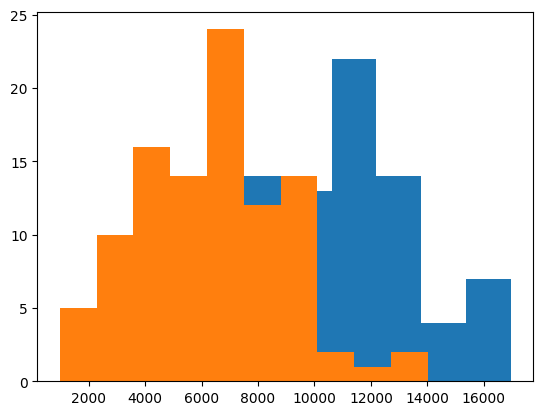

In [41]:
plt.hist(somatic_count_table["Mutect(Raw)"])
plt.hist(somatic_count_table["Mutect(Filtered)"])
plt.show()
plt.hist(somatic_count_table["Varscan(Raw)"])
plt.hist(somatic_count_table["Varscan(Filtered)"])
plt.show()

In [43]:
somatic_count_table.index = sample_dir

In [45]:
germline_count_table.to_csv("germline_count.csv", header=True, index=True)
somatic_count_table.to_csv("somatic_count.csv", header=True, index=True)

In [46]:
somatic_count_table.sort_values("Merged")

,Mutect(Raw),Mutect(Filtered),Varscan(Raw),Varscan(Filtered),Merged
SU2CLC-MDA-1631,2883,0,10057,6582,0
SU2CLC-DFC-DF0669,7459,1,11269,7670,0
SU2CLC-MDA-1630,2367,0,8450,5108,0
SU2CLC-MGH-1565,3670,0,8869,6228,0
SU2CLC-DFC-DF0047,2627,15,5604,3596,3
...,...,...,...,...,...
SU2CLC-MGH-1048,6403,2080,10796,9275,1890
SU2CLC-DFC-DF0668,5826,2197,16395,12788,2111
SU2CLC-DFC-1429,9228,2948,15666,10664,2724
SU2CLC-DFC-DF0768,6264,2904,15932,14010,2778
